# Generating Noise Images

I watched [this video](https://youtu.be/lctXaT9pxA0) by Sebastian Lague where he procedurally generated planets and moons in Unity. In this video he just briefly showed some trippy art made with noise generation algorithms, which inspired me to make this. In this notebook I've made some cool art using noise sampling algorithms

In [2]:
%matplotlib widget
import ipywidgets as widgets
import numpy as np
from matplotlib import pyplot as plt
from skimage import transform as skt
from PIL import Image
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = [8, 6]

Let's start with basic white noise. Just generate an image where each pixel value is generated randomly.

Button(description='Generate', style=ButtonStyle())

Output()

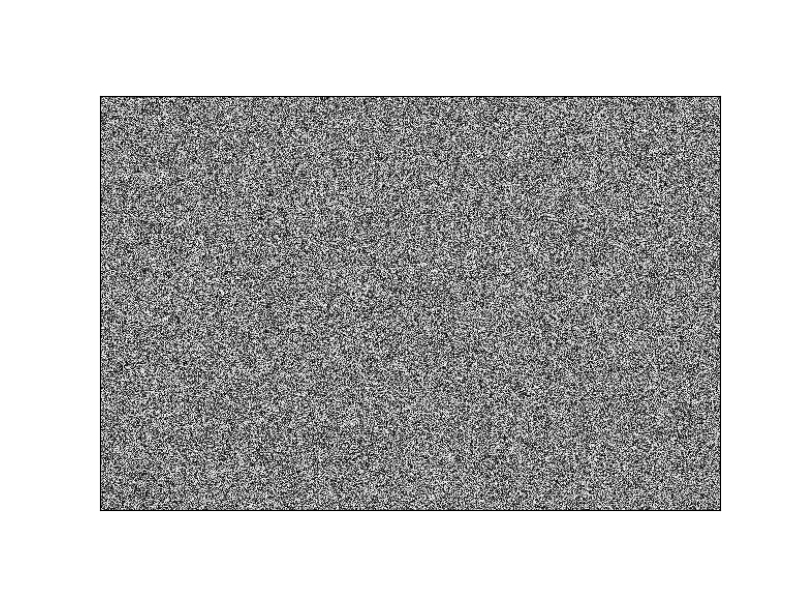

In [3]:
# Create random noise image
rng = np.random.default_rng()
white_noise = rng.random((400, 600))

# Generate new white noise
generate_wn = widgets.Button(description='Generate')
output = widgets.Output()
display(generate_wn, output)

with output:
    # Show image
    fig_wn = plt.figure()
    img_wn = plt.imshow(white_noise)
    plt.xticks([])
    plt.yticks([])
    
@generate_wn.on_click
def new_white_noise(event):
    global white_noise
    white_noise = rng.random((400, 600))
    img_wn.set_data(white_noise)
    fig_wn.canvas.draw()

Seems kind of boring, like TV static. How do we make this more... organic?

What if we sample the image, and then scaled it up, interpolating between the sampled points to create a smooth boundary? I think this is called value noise.

There's also Perlin noise but that algorithm seems a bit too out of my reach for now... I'll just stick with this one

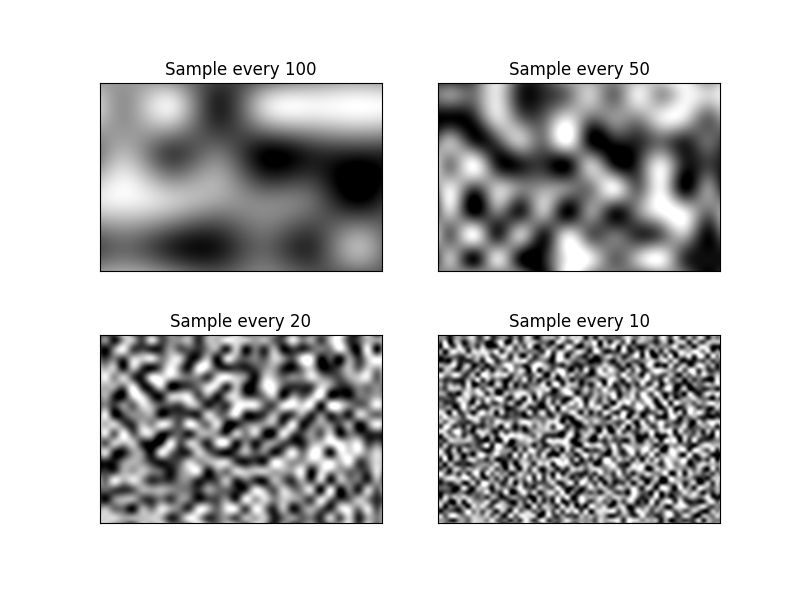

In [4]:
def sample_noise(n):
    """
    Sample points within the buffer.
    Then rescale while cubically 
    interpolating between points
    This can be done using scikit-image's
    rescale function. We set the order to
    3 to indicate cubic interpolation
    """
    ips = np.arange(0, 600, n)
    jps = np.arange(0, 400, n)
    j,i = np.meshgrid(ips,jps)
    return skt.rescale(white_noise[i,j], n, order=3)

# Get some samples
sample_sizes = [ 100, 50, 20, 10 ]
samples = [ sample_noise(N) for N in sample_sizes ]
sample_images = []

# Plot them
fig_samp = plt.figure()
for i, (size, sample) in enumerate(zip(sample_sizes, samples)):
    plt.subplot(2,2,i+1)
    sample_images.append(plt.imshow(sample))
    plt.title(f'Sample every {size}')
    plt.xticks([])
    plt.yticks([]);
    
@generate_wn.on_click
def resample_wn(event):
    samples = [ sample_noise(N) for N in sample_sizes ]
    for image, sample in zip(sample_images, samples):
        image.set_data(sample)
    fig_samp.canvas.draw()

As you can see, we can sample the noise buffer at any resolution to get more and more detail in the noise, but it still looks more structured.

What's more: We can sum these individual noise points together to create a more complex pattern, called fractal noise.

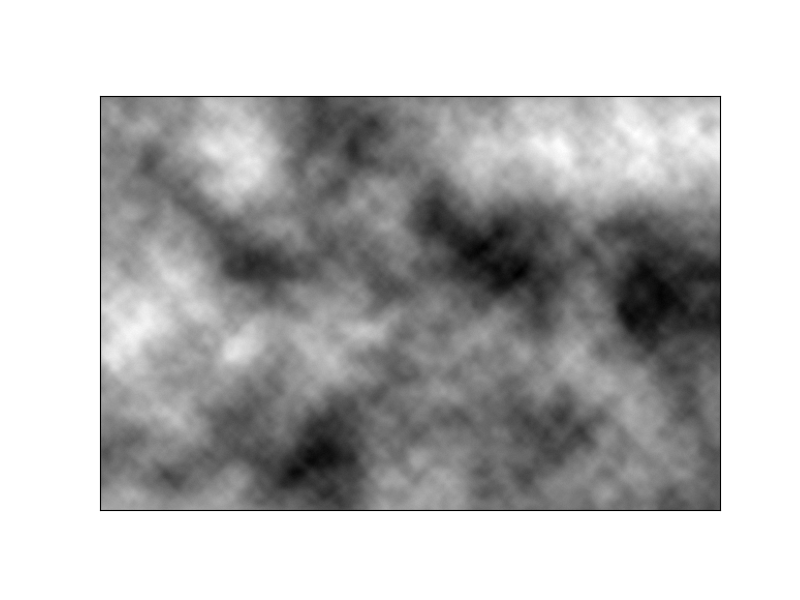

In [5]:
# Scales and factors
# Scales are all common factors of the image dimensions
# Factors decrease in contribution
scales = [ 100, 50, 20, 10, 5, 1 ]
factors = np.array([ [[0.5**i]] for i in range(len(scales)) ])

# Noise is a normalized weighted sum samples at different scales
sampled_images = np.array([ sample_noise(scale) for scale in scales ])
fractal_noise = (factors*sampled_images).sum(axis=0)
fractal_noise /= factors.sum(axis=0)

# Show result
fig_fn = plt.figure()
img_fn = plt.imshow(fractal_noise)
plt.xticks([])
plt.yticks([])

@generate_wn.on_click
def resample_fractal(event):
    global fractal_noise
    sampled_images = np.array([ sample_noise(scale) for scale in scales ])
    fractal_noise = (factors*sampled_images).sum(axis=0)
    fractal_noise /= factors.sum(axis=0)
    img_fn.set_data(fractal_noise)
    fig_fn.canvas.draw()

Now that's pretty nifty! However, Sebastian Lague did something even more awesome. He mentioned offsetting each point using more noise, which created the trippy art that I wanted to recreate. Let's try doing that. I'll generate another noise buffer, and then scale it up and convert it to integers to create a pixel offset buffer. Then I'll create a new image by indexing pixels from the old image using the offset buffer.

IntSlider(value=100, description='Max Offset:', max=300)

Button(description='Generate', style=ButtonStyle())

Output()

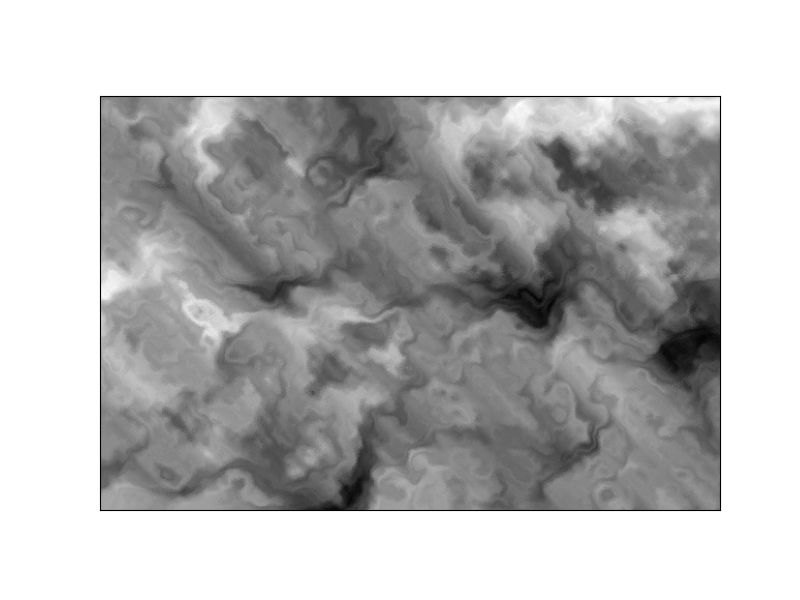

In [6]:
def make_noise():
    """
    Create a fractal noise image
    """
    # Scales are all common factors of the image dimensions
    scales = [ 100, 50, 20, 10, 5, 1 ]

    # Get sampled images and factors
    sampled_images = np.array([ sample_noise(scale) for scale in scales ])
    factors = np.array([ [[0.5**i]] for i in range(len(scales)) ])

    # Noise is a normalized weighted sum of these samples
    fractal_noise = (factors*sampled_images).sum(axis=0)
    fractal_noise /= factors.sum(axis=0)
    return fractal_noise


def make_offsetted_noise(offset):
    """
    Generate offset image
    """
    # Get offset noise
    offset_noise = ( make_noise() * offset * 2 - offset ).astype( np.int8 )

    # Offset the noise buffer using te offsets generated
    j_index, i_index = np.meshgrid(np.arange(600), np.arange(400))
    i_offset = np.clip(offset_noise + i_index, 0, 399)
    j_offset = np.clip(offset_noise + j_index, 0, 599)

    # Update offset_noise
    offsetted_noise = fractal_noise[i_offset, j_offset]

    # Normalize
    offsetted_min = np.min(offsetted_noise)
    offsetted_max = np.max(offsetted_noise)
    offsetted_noise = (offsetted_noise - offsetted_min) / (offsetted_max - offsetted_min)

    # Return
    return offsetted_noise


# Widgets layout
max_offset_slider = widgets.IntSlider(100, min=0, max=300, description='Max Offset:')
generate_offsetted = widgets.Button(description='Generate')
output = widgets.Output()
display(max_offset_slider, generate_offsetted, output)

# Generate plot
with output:
    offset = max_offset_slider.value
    offsetted_noise = make_offsetted_noise(offset)
    fig = plt.figure()
    img = plt.imshow(offsetted_noise)
    plt.xticks([])
    plt.yticks([])


# Regenerate on rerun click
@generate_offsetted.on_click
def play_with_offset(event):
    global offsetted_noise
    offsetted_noise = make_offsetted_noise(max_offset_slider.value)
    img.set_data(offsetted_noise)
    fig.canvas.draw_idle()

Now THAT's what I'm looking for! Let's add some color to this! First, lemme generate some colors. What I'm doing here is generating gradients between consecutive pairs of colors and then stiching all of the gradients together to create one long multi-gradient colormap

Colorspace: 1024


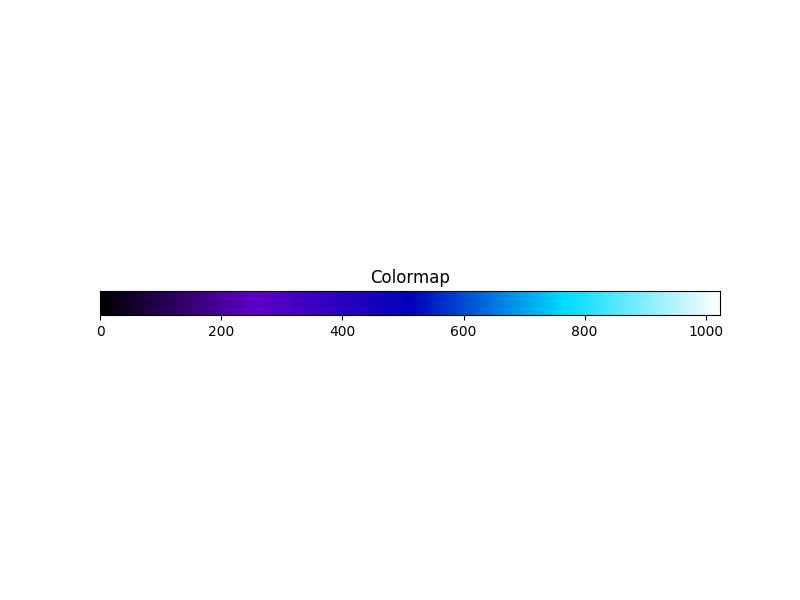

In [7]:
# Gradient colors
gradient = np.array([
    0x000000,
    0x5e00c7,
    0x0000bb,
    0x00ddff,
    0xffffff
])

# Create colormap
channel_shifts = np.array([[16, 8, 0]])
channel_mask = 0xff
gradient_channels = (gradient.reshape(-1,1) >> channel_shifts) & channel_mask
gradient_channels = gradient_channels.reshape(-1,1,3)
gradient_start = gradient_channels[:-1]
gradient_end = gradient_channels[1:]
alpha = np.linspace(0, 1, 256).reshape(1,-1,1)
colormap = (1 - alpha) * gradient_start + alpha * gradient_end
colormap = colormap.astype(np.uint8).reshape(-1,3)
colorspace = colormap.shape[0]
print('Colorspace:', colorspace)

# Test colormap
index_image, _ = np.meshgrid(np.arange(colorspace), np.arange(40))
colored_image = colormap[index_image]
plt.figure();
plt.imshow(colored_image)
plt.title('Colormap')
plt.yticks([]);

Now we just apply the colormap to the image!

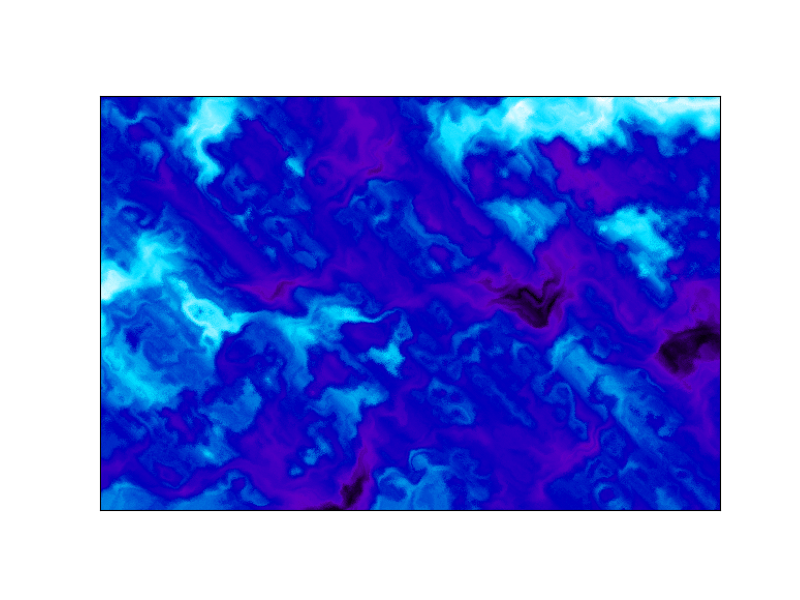

In [8]:
# Map offsetted_noise to colorspace
index_noise = (offsetted_noise * colorspace).astype(np.uint16)
index_noise = np.clip(index_noise, 0, colorspace - 1)
colored_noise = colormap[index_noise]

# Show the image
fig_cn = plt.figure();
img_cn = plt.imshow(colored_noise)
plt.xticks([])
plt.yticks([])

@generate_offsetted.on_click
def regen_image(event):
    global colored_noise
    index_noise = (offsetted_noise * colorspace).astype(np.uint16)
    index_noise = np.clip(index_noise, 0, colorspace - 1)
    colored_noise = colormap[index_noise]
    img_cn.set_data(colored_noise)
    fig_cn.canvas.draw()

Finally, I do want to control the gradient a bit more. Specifically, I want there to be more of a bias towards the upper or lower colors. Luckily, the same video also has a cool bias function that I can use, demoed below. This mapps the input values to a new set of output values, and depending on the bias value, the output will be skewed more towards the lower or upper values

FloatSlider(value=0.01, description='Bias:', max=0.99, min=-0.99)

Output()

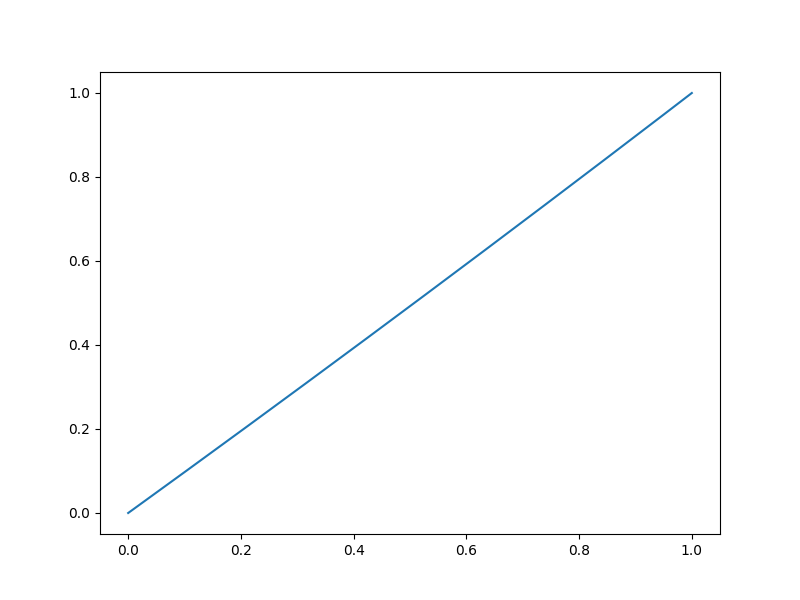

In [9]:
def bias_func(bias, x):
    """
    Output biased y given linear x
    """
    k = (1 - bias)**3
    return (x*k)/(x*k - x + 1)

# Widgets
bias_slider = widgets.FloatSlider(0.01, min=-0.99, max=0.99, description='Bias:')
output = widgets.Output()
display(bias_slider, output)

# Generate plots
with output:
    bias = bias_slider.value
    x = np.linspace(0, 1, 200)
    y = bias_func(bias, x)
    fig_bias = plt.figure()
    line_bias, = plt.plot(x,y)
    
def handle_slider_line(event):
    """
    Update plot with slider
    """
    bias = bias_slider.value
    y = bias_func(bias, x)
    line_bias.set_data(x, y)
    fig_bias.canvas.draw()
    
# Listen for changes
bias_slider.observe(handle_slider_line, 'value')

Here's the result of putting all of this together. I've gained a fascination with art that can be generated using computer algorithms. I'll definitely be experimenting with things like these more in the future, especially using OpenGL to accelerate some of these.

Button(description='Generate', style=ButtonStyle())

Output()

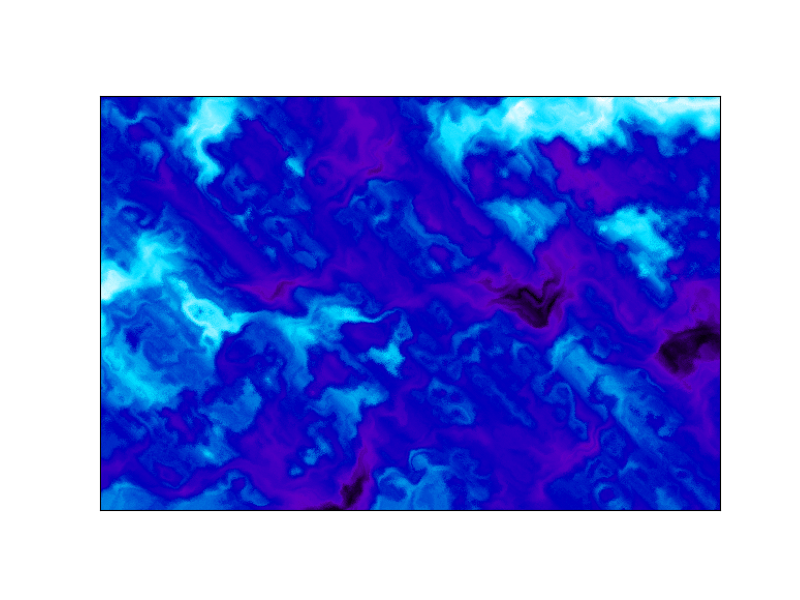

In [10]:
def make_bias_noise(bias):
    """
    Map offsetted_noise to bias space, then colorspace, then color
    """
    biased_noise = bias_func(bias, offsetted_noise)
    index_noise = (biased_noise * colorspace).astype(np.uint16)
    index_noise = np.clip(index_noise, 0, colorspace - 1)
    return colormap[index_noise] 

# Widgets
generate_biased_button = widgets.Button(description='Generate')
output = widgets.Output()
display(generate_biased_button, output)

with output:
    bias = bias_slider.value
    colored_noisse = make_bias_noise(bias)
    fig_biased = plt.figure()
    img_biased = plt.imshow(colored_noise)
    plt.xticks([])
    plt.yticks([])

@generate_biased_button.on_click
def image_bias_handler(event):
    """
    Update plot with slider
    """
    bias = bias_slider.value
    colored_noise = make_bias_noise(bias)
    img_biased.set_data(colored_noise)
    fig_biased.canvas.draw()